# 2. Entrenamiento de RNNs en una Serie de Tiempo

**2.0 Imports necesarios**

In [1]:
import pandas
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
import matplotlib.pyplot as plt
import time

/home/seba/.virtualenvs/tareas-ml/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 820M (CNMeM is disabled, cuDNN not available)


**2.1 Creación de conjuntos de entrenamiento y prueba**

En primer lugar, se crean los conjuntos de entrenamiento y de prueba por medio de la función *create_sets*. Esta función también se encarga de escalar los datos de cada conjunto. El dataset original está compuesto por un total de 144 registros, de los cuales 96 estarán destinados a conformar el conjunto de entrenamiento, mientras que los 48 restantes formarán parte del conjunto de pruebas.

In [2]:
# Función para la creación de conjuntos de entrenamiento y prueba
def create_sets(file_name):
    # Se lee archivo que contiene todos los datos
    dataframe = pandas.read_csv(file_name, sep=',', usecols=[1], engine='python', skipfooter=3)
    # Se utiliza precisión de 32 bits para atributos numéricos
    dataframe[:] = dataframe[:].astype('float32')
    # Se crean conjuntos de entrenamiento y de prueba
    df_train, df_test = dataframe[0:96].values, dataframe[96:].values
    # Se escalan los datos de cada conjunto
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
    stream_train_scaled = scaler.transform(df_train)
    stream_test_scaled = scaler.transform(df_test)
    return scaler, list(stream_train_scaled), list(stream_test_scaled)

# Se crean conjuntos a partir de archivo .csv
scaler, train_set, test_set = create_sets('international-airline-passengers.csv')

**2.2 Generación de atributos predictores y atributo a predecir**

Ya creados los conjuntos de entrenamiento y de prueba, se procede a construir, para cada caso, la matriz X y el vector Y. La matriz X contendrá, para cada registro, la cantidad de pasajeros en los tiempos x(t-2), x(t-1) y x(t), o en otras palabras, los atributos predictores. Por otro lado, el vector Y almacenará en la casilla correspondiente la cantidad de pasajeros en el tiempo x(t+1), es decir, el atributo a predecir. El procedimiento descrito será llevado a cabo por medio de la función *create_dataset*.

In [3]:
# Función encargada de separar valores predictores y valores a predecir
def create_dataset(sequence, lag):
    dataX = []
    dataY = []
    for i in range(lag, len(sequence)):
        # Se crea matriz X
        dataX.append(sequence[i - lag : i])
        # Se crea vector Y
        dataY.append(sequence[i])
    return np.array(dataX), np.array(dataY)

Así, se crea la matriz X y el vector Y en base a los conjuntos de entrenamiento y de prueba. Se utilizará lag = 3, en primera instancia.

In [4]:
# Inicialmente, se usará lag = 3
lag = 3
# Se crea matriz X y vector Y en base a conjuntos de entrenamiento y prueba
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)

In [5]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

De esta forma, la matriz X poseen dimensiones (número de ejemplos, time step, número de atributos predictores) tanto para el caso de entrenamiento como para el caso de pruebas.

**2.3 Entrenamiento de red LSTM**

A partir de las matrices creadas en la sección anterior, se entrena y posteriormente se evalúa una red LSTM. Recordar que se está utilizando un lag de 3.

In [6]:
ti = time.time()
model = Sequential()
model.add(LSTM(4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1)
tf = time.time()

Epoch 1/100
93/93 [==============================] - 0s - loss: 0.0663     
Epoch 2/100
93/93 [==============================] - 0s - loss: 0.0276     
Epoch 3/100
93/93 [==============================] - 0s - loss: 0.0192     
Epoch 4/100
93/93 [==============================] - 0s - loss: 0.0174     
Epoch 5/100
93/93 [==============================] - 0s - loss: 0.0161     
Epoch 6/100
93/93 [==============================] - 0s - loss: 0.0152     
Epoch 7/100
93/93 [==============================] - 0s - loss: 0.0144     
Epoch 8/100
93/93 [==============================] - 0s - loss: 0.0139     
Epoch 9/100
93/93 [==============================] - 0s - loss: 0.0132     
Epoch 10/100
93/93 [==============================] - 0s - loss: 0.0127     
Epoch 11/100
93/93 [==============================] - 0s - loss: 0.0123     
Epoch 12/100
93/93 [==============================] - 0s - loss: 0.0121     
Epoch 13/100
93/93 [==============================] - 0s - loss: 0.0118     
Epoch 14

**2.4 Determinación de error y de prueba**

...

In [7]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

...

In [8]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 51.127833128 [s]
Error de entrenamiento: 22.3581547754 RMSE
Error de prueba: 66.6740555801 RMSE


...

**2.5 Comparación de predicciones**

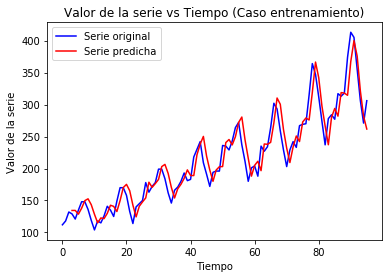

In [9]:
plt.plot(range(len(train_set)), scaler.inverse_transform(train_set), 'b')
plt.plot(range(len(train_set))[lag:], list(trainPredict), 'r')
plt.title('Valor de la serie vs Tiempo (Caso entrenamiento)')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la serie')
plt.legend(['Serie original', 'Serie predicha'], loc='best')
plt.show()

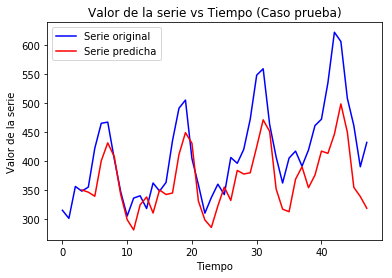

In [10]:
plt.plot(range(len(test_set)), scaler.inverse_transform(test_set), 'b')
plt.plot(range(len(test_set))[lag:], list(testPredict), 'r')
plt.title('Valor de la serie vs Tiempo (Caso prueba)')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la serie')
plt.legend(['Serie original', 'Serie predicha'], loc='best')
plt.show()

...

**2.6 Determinación de bloques LSTM**

In [42]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

kfold = cross_validation.KFold(trainX.shape[0], 5)

for nb in range(4, 13, 2):
    cv_errors = []
    times = []
    print 'Numero de bloques:', nb
    for i, (train, val) in enumerate(kfold):
        model = None
        ti = time.time()
        model = Sequential()
        model.add(LSTM(nb, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX[train], trainY[train], epochs=100, batch_size=1, verbose=0)
        tf = time.time()
        times.append(tf - ti)
        trainPredict_val = model.predict(trainX[val])
        trainPredict_val = scaler.inverse_transform(trainPredict_val)
        trainY_val = scaler.inverse_transform(trainY[val])
        error = math.sqrt(mean_squared_error(trainY_val, trainPredict_val))
        cv_errors.append(error)
    mean_time = np.mean(times)
    mse_cv = np.mean(cv_errors)
    print 'Tiempo de entrenamiento promedio:', tf - ti, '[s]'
    print 'Error promedio:', mse_cv
    print ''

Numero de bloques: 4
Tiempo de entrenamiento promedio: 31.7884318829 [s]
Error promedio: 23.0393569081

Numero de bloques: 6
Tiempo de entrenamiento promedio: 35.0732390881 [s]
Error promedio: 25.3316190651

Numero de bloques: 8
Tiempo de entrenamiento promedio: 35.2910139561 [s]
Error promedio: 22.9159651219

Numero de bloques: 10
Tiempo de entrenamiento promedio: 32.4763169289 [s]
Error promedio: 22.6611613597

Numero de bloques: 12
Tiempo de entrenamiento promedio: 34.2305350304 [s]
Error promedio: 22.6869639257



**2.7 Variación de lag**

In [43]:
for lag in range(1, 5):
    trainX, trainY = create_dataset(train_set, lag)
    testX, testY = create_dataset(test_set, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    t_i = time.time()
    model = Sequential()
    model.add(LSTM(10, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
    t_f = time.time()
    
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    
    print 'Lag:', lag
    print 'Tiempo de entrenamiento:', tf - ti, '[s]'
    print 'Error de entrenamiento:', trainScore, 'RMSE'
    print 'Error de prueba:', testScore, 'RMSE\n'

Lag: 1
Tiempo de entrenamiento: 34.2305350304 [s]
Error de entrenamiento: 23.2630289959 RMSE
Error de prueba: 48.5479662735 RMSE

Lag: 2
Tiempo de entrenamiento: 34.2305350304 [s]
Error de entrenamiento: 21.6572054037 RMSE
Error de prueba: 50.7686138124 RMSE

Lag: 3
Tiempo de entrenamiento: 34.2305350304 [s]
Error de entrenamiento: 21.2734425209 RMSE
Error de prueba: 56.7303341304 RMSE

Lag: 4
Tiempo de entrenamiento: 34.2305350304 [s]
Error de entrenamiento: 21.4877547058 RMSE
Error de prueba: 62.0957532232 RMSE



**2.8 Comparación con RNN simple y GRU**

In [44]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [45]:
ti = time.time()
model = Sequential()
model.add(GRU(10, input_shape=(None, lag), recurrent_initializer='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 31.8812048435 [s]
Error de entrenamiento: 23.1554803347 RMSE
Error de prueba: 45.8769983173 RMSE


In [46]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

ti = time.time()
model = Sequential()
model.add(SimpleRNN(10, input_shape=(None, lag), recurrent_initializer='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 20.8563990593 [s]
Error de entrenamiento: 23.0407049474 RMSE
Error de prueba: 69.0624929299 RMSE


**2.9 Entrenamiento de red LSTM con timestep = 3**

In [47]:
lag = 1
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

ti = time.time()
model = Sequential()
model.add(LSTM(10, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1)
tf = time.time()

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

Epoch 1/100
95/95 [==============================] - 0s - loss: 0.1234     
Epoch 2/100
95/95 [==============================] - 0s - loss: 0.0549     
Epoch 3/100
95/95 [==============================] - 0s - loss: 0.0341     
Epoch 4/100
95/95 [==============================] - 0s - loss: 0.0283     
Epoch 5/100
95/95 [==============================] - 0s - loss: 0.0246     
Epoch 6/100
95/95 [==============================] - 0s - loss: 0.0213     
Epoch 7/100
95/95 [==============================] - 0s - loss: 0.0186     
Epoch 8/100
95/95 [==============================] - 0s - loss: 0.0155     
Epoch 9/100
95/95 [==============================] - 0s - loss: 0.0131     
Epoch 10/100
95/95 [==============================] - 0s - loss: 0.0111     
Epoch 11/100
95/95 [==============================] - 0s - loss: 0.0094     
Epoch 12/100
95/95 [==============================] - 0s - loss: 0.0081     
Epoch 13/100
95/95 [==============================] - 0s - loss: 0.0073     
Epoch 14

In [48]:
print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 50.8571610451 [s]
Error de entrenamiento: 24.0579477735 RMSE
Error de prueba: 55.7950897572 RMSE


**2.10 Entrenamiento de red LSTM con memoria entre batches**

**2.10.1 Batch size = 1**

In [49]:
lag = 1
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1
ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0139     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0187     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0134     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0116     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0110     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0108     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0106     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0104     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0103     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0101     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0099     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0097     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0095     
Epoch 1/1
95/95 [=====================

In [50]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 43.1905229092 [s]
Error de entrenamiento: 20.5878342046 RMSE
Error de prueba: 48.1419765106 RMSE


**2.10.2 Batch size = 3**

In [51]:
lag = 3
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 3
ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
93/93 [==============================] - 0s - loss: 0.1413     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0544      
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0257     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0273     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0239     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0202     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0173     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0149     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0131     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0119     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0113     
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0110      
Epoch 1/1
93/93 [==============================] - 0s - loss: 0.0108      
Epoch 1/1
93/93 [==================

In [52]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 28.4600529671 [s]
Error de entrenamiento: 25.037101376 RMSE
Error de prueba: 60.219952067 RMSE


**2.11 Entrenamiento de LSTM apilada**

In [59]:
lag = 1
trainX, trainY = create_dataset(train_set, lag)
testX, testY = create_dataset(test_set, lag)
   
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1

ti = time.time()
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model.add(LSTM(10, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, shuffle=False)
    model.reset_states()
tf = time.time()

Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0147     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0277     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0230     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0204     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0267     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0248     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0185     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0193     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0201     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0182     
Epoch 1/1
95/95 [==============================] - 1s - loss: 0.0180     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0169     
Epoch 1/1
95/95 [==============================] - 0s - loss: 0.0161     
Epoch 1/1
95/95 [=====================

In [60]:
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print 'Tiempo de entrenamiento:', tf - ti, '[s]'
print 'Error de entrenamiento:', trainScore, 'RMSE'
print 'Error de prueba:', testScore, 'RMSE'

Tiempo de entrenamiento: 119.60284996 [s]
Error de entrenamiento: 30.1918729849 RMSE
Error de prueba: 63.1720759643 RMSE
